# Modélisation ML : Prédiction des Prix Immobiliers

Notebook complet pour la prédiction des prix immobiliers avec comparaison de modèles et optimisation.

## 1. Importations

In [7]:
# Manipulation de données
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

# Modèles
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Métriques
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Sauvegarde
import pickle
from datetime import datetime
import os

# Progress bar
from tqdm import tqdm

print("Tous les imports effectués avec succès")

Tous les imports effectués avec succès


## 2. Chargement des Données

In [8]:
# Charger les deux fichiers CSV
df_avito = pd.read_csv("../data/clean_data/avito_vendre_clean.csv")
df_mubawab = pd.read_csv("../data/clean_data/annonces_nettoyees_mubawab.csv")

print(f"Avito : {len(df_avito)} annonces")
print(f"Mubawab : {len(df_mubawab)} annonces")

# Renommer les colonnes pour harmonisation
df_avito = df_avito.rename(columns={
    'prix': 'price',
    'surface': 'surface_m2',
    'ville': 'city',
    'type_bien': 'property_type',
    'nb_chambres': 'num_rooms',
    'nb_salle_de_bains': 'num_bathrooms'
})

df_mubawab = df_mubawab.rename(columns={
    'prix': 'price',
    'surface': 'surface_m2',
    'ville': 'city',
    'type_bien': 'property_type',
    'nb_chambres': 'num_rooms',
    'nb_salle_de_bain': 'num_bathrooms'
})

# Fusionner les données
df = pd.concat([df_avito, df_mubawab], ignore_index=True)

print(f"\nDonnées fusionnées : {len(df)} annonces")
print(f"Dimensions : {df.shape}")
print(f"\nColonnes : {df.columns.tolist()}")
print(f"\nAperçu des données :")
print(df.head())
print(f"\nTypes de données :")
print(df.dtypes)

# supprimer les doublons
df = df.drop_duplicates().reset_index(drop=True)
print(f"\nAprès suppression des doublons : {len(df)} annonces")
print(f"Dimensions : {df.shape}")


Avito : 5229 annonces
Mubawab : 14746 annonces

Données fusionnées : 19975 annonces
Dimensions : (19975, 10)

Colonnes : ['id', 'city', 'price', 'surface_m2', 'quartier', 'property_type', 'num_rooms', 'nb_salle_de_bain', 'url_annonce', 'num_bathrooms']

Aperçu des données :
         id        city       price  surface_m2             quartier  \
0  57346043  Casablanca   2999986.1       287.0         Hay Laymouna   
1  57029300      Tanger   4650212.3       113.0               Ahlane   
2  57374711   Marrakech   3500163.7       260.0  Route de Tahanaoute   
3  57333583  Casablanca  46002305.4       102.0         Sidi Maarouf   
4  56921942  Casablanca   3500163.7       378.0       Sidi Bernoussi   

  property_type  num_rooms  nb_salle_de_bain  \
0        Maison          7               2.0   
1        Maison         12               5.0   
2         Villa          4               1.0   
3        Maison         12               5.0   
4        Maison          4               1.0   

   

## 3. Feature Engineering

In [9]:
# Créer une copie pour le feature engineering
df_features = df.copy()

# Supprimer les valeurs manquantes UNIQUEMENT sur les colonnes critiques (Correction ici)
critical_columns = ['price', 'surface_m2', 'num_rooms', 'num_bathrooms']
df_features = df_features.dropna(subset=critical_columns)

print("Création des nouvelles features...")

# 1. Prix par m² -> DÉSACTIVÉ (Data Leakage)
# df_features['price_per_m2'] = df_features['price'] / df_features['surface_m2']

# 2. Surface * Chambres
df_features['surface_rooms'] = df_features['surface_m2'] * df_features['num_rooms']

# 3. Ratio salles de bain / chambres
df_features['bathrooms_rooms_ratio'] = df_features['num_bathrooms'] / (df_features['num_rooms'] + 1)

# 4. Total pièces
df_features['total_rooms'] = df_features['num_rooms'] + df_features['num_bathrooms']

# 5. Surface par pièce
df_features['surface_per_room'] = df_features['surface_m2'] / (df_features['total_rooms'] + 1)

print("\nNouvelles features créées :")
new_features = ['surface_rooms', 'bathrooms_rooms_ratio', 'total_rooms', 'surface_per_room']
print(df_features[new_features].describe())

print(f"\nDataFrame avec features : {df_features.shape}")

Création des nouvelles features...

Nouvelles features créées :
       surface_rooms  bathrooms_rooms_ratio   total_rooms  surface_per_room
count   1.474600e+04           14746.000000  14746.000000      14746.000000
mean    3.148653e+03               0.586251      6.095077         44.396495
std     8.157614e+04               0.307786      4.968785        191.464101
min     2.878048e-01               0.028571      2.000000          0.095935
25%     1.800000e+02               0.500000      4.000000         17.000000
50%     4.050000e+02               0.500000      5.000000         22.857143
75%     1.228000e+03               0.750000      8.000000         35.592857
max     8.940000e+06              26.666667    200.000000       9000.000000

DataFrame avec features : (14746, 14)


## 4. Target Encoding des Variables Catégorielles

DÉFINITION DES FEATURES
📊 Features numériques (7): ['surface_m2', 'num_rooms', 'num_bathrooms', 'surface_rooms', 'bathrooms_rooms_ratio', 'total_rooms', 'surface_per_room']
📊 Features catégorielles (3): ['city', 'quartier', 'property_type']

✓ X: (14746, 10)
✓ y: (14746,)

DÉTECTION ET TRAITEMENT DES OUTLIERS

🔍 Top 10 des prix les plus élevés :
             city                              quartier         price  \
19443      Tanger                                Médina  1.000000e+11   
17028  Casablanca                    Derb Moulay Cherif  3.500000e+09   
6261    Marrakech                  Ennakhil (Palmeraie)  2.300000e+09   
18431   Marrakech                   Route de Ouarzazate  1.900000e+09   
6352       Tanger                               Achakar  1.500000e+09   
16265      Tanger                                 Manar  1.200000e+09   
14417  Casablanca  Derb Milan (Hay Omar Bnou Alkhattab)  9.500000e+08   
18348      Tanger                           Bella Vista  9.500000e+0

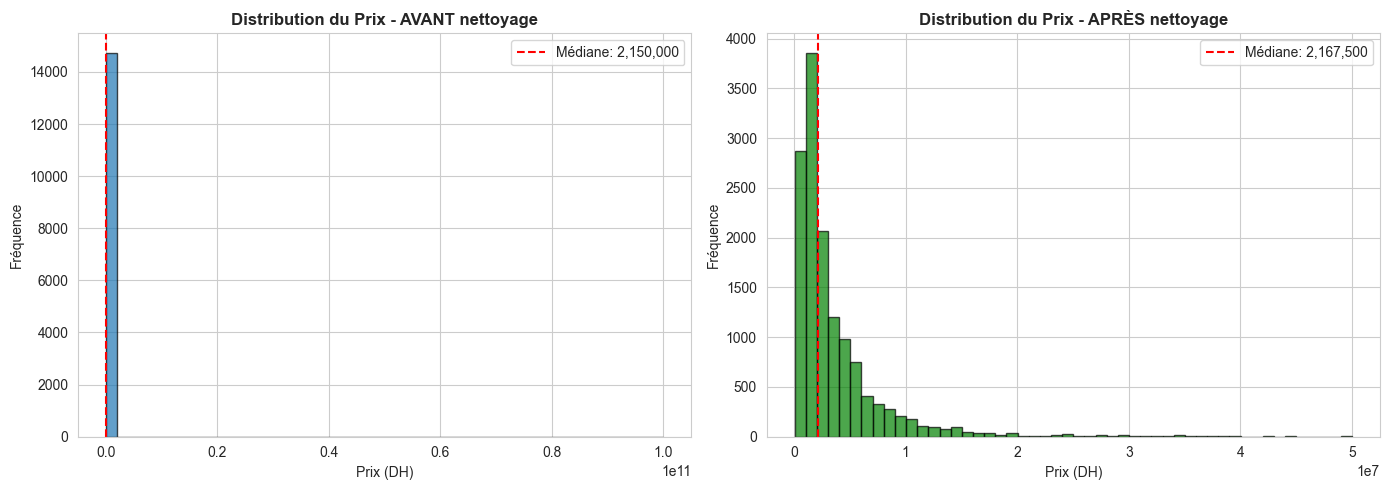


✅ Outliers traités avec succès !


In [10]:
# ============================================
# DÉFINITION DES FEATURES
# ============================================

print("="*60)
print("DÉFINITION DES FEATURES")
print("="*60)

# Séparer features numériques et catégorielles
numeric_features = ['surface_m2', 'num_rooms', 'num_bathrooms',
                    'surface_rooms', 'bathrooms_rooms_ratio',
                    'total_rooms', 'surface_per_room']

categorical_features = ['city', 'quartier', 'property_type']

# Vérifier que les colonnes existent
categorical_features = [f for f in categorical_features if f in df_features.columns]

print(f"📊 Features numériques ({len(numeric_features)}): {numeric_features}")
print(f"📊 Features catégorielles ({len(categorical_features)}): {categorical_features}")

# Créer X et y
y = df_features['price'].copy()
X = df_features[numeric_features + categorical_features].copy()

print(f"\n✓ X: {X.shape}")
print(f"✓ y: {y.shape}")

# ============================================
# TRAITEMENT DES OUTLIERS DANS LE PRIX
# ============================================

print("\n" + "="*60)
print("DÉTECTION ET TRAITEMENT DES OUTLIERS")
print("="*60)

# Afficher les prix les plus élevés
print("\n🔍 Top 10 des prix les plus élevés :")
print(df_features.nlargest(10, 'price')[['city', 'quartier', 'price', 'surface_m2', 'num_rooms']])

# Méthode IQR pour détecter les outliers
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\n📊 Analyse IQR du prix :")
print(f"  Q1 (25%) : {Q1:,.0f} DH")
print(f"  Q3 (75%) : {Q3:,.0f} DH")
print(f"  IQR : {IQR:,.0f} DH")
print(f"  Limite inférieure : {lower_bound:,.0f} DH")
print(f"  Limite supérieure : {upper_bound:,.0f} DH")

# Compter les outliers
outliers_mask = (y < lower_bound) | (y > upper_bound)
n_outliers = outliers_mask.sum()
print(f"\n⚠️ Nombre d'outliers détectés : {n_outliers} ({n_outliers/len(y)*100:.2f}%)")

# Option 1 : Supprimer les outliers extrêmes (recommandé)
# On garde les biens entre 50k et 50M DH (limites réalistes pour le Maroc)
price_min_realistic = 50_000
price_max_realistic = 50_000_000

mask_realistic = (y >= price_min_realistic) & (y <= price_max_realistic)
n_removed = (~mask_realistic).sum()

print(f"\n🎯 Application de limites réalistes :")
print(f"  Prix minimum : {price_min_realistic:,} DH")
print(f"  Prix maximum : {price_max_realistic:,} DH")
print(f"  Lignes à supprimer : {n_removed} ({n_removed/len(y)*100:.2f}%)")

# Appliquer le filtre
df_clean = df_features[mask_realistic].copy()
y_clean = df_clean['price'].copy()
X_clean = df_clean[numeric_features + categorical_features].copy()

print(f"\n✓ Données après nettoyage : {X_clean.shape}")
print(f"\n📈 Nouvelles statistiques du prix :")
print(y_clean.describe())

# Visualisation avant/après
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avant
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution du Prix - AVANT nettoyage', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Prix (DH)')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(y.median(), color='red', linestyle='--', label=f'Médiane: {y.median():,.0f}')
axes[0].legend()

# Après
axes[1].hist(y_clean, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution du Prix - APRÈS nettoyage', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Prix (DH)')
axes[1].set_ylabel('Fréquence')
axes[1].axvline(y_clean.median(), color='red', linestyle='--', label=f'Médiane: {y_clean.median():,.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Outliers traités avec succès !")

## 5. Préparation du Dataset (Train/Val/Test)

In [11]:
# ============================================
# SPLIT TRAIN / VALIDATION / TEST
# ============================================

print("\n" + "="*60)
print("SPLIT DES DONNÉES")
print("="*60)

# Split train / temp (70% / 30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42
)

# Split temp en validation / test (15% / 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"\n✓ Split effectué :")
print(f"  Train      : {X_train.shape[0]:,} lignes ({X_train.shape[0]/len(X_clean)*100:.1f}%)")
print(f"  Validation : {X_val.shape[0]:,} lignes ({X_val.shape[0]/len(X_clean)*100:.1f}%)")
print(f"  Test       : {X_test.shape[0]:,} lignes ({X_test.shape[0]/len(X_clean)*100:.1f}%)")

# ============================================
# TARGET ENCODING
# ============================================

print("\n" + "="*60)
print("TARGET ENCODING")
print("="*60)

# Créer le Target Encoder
target_encoder = TargetEncoder(cols=categorical_features)

# Fit sur train uniquement
X_train_encoded = X_train.copy()
X_train_encoded[categorical_features] = target_encoder.fit_transform(
    X_train[categorical_features], y_train
)

# Transform sur validation et test
X_val_encoded = X_val.copy()
X_val_encoded[categorical_features] = target_encoder.transform(
    X_val[categorical_features]
)

X_test_encoded = X_test.copy()
X_test_encoded[categorical_features] = target_encoder.transform(
    X_test[categorical_features]
)

print(f"Target Encoding appliqué sur : {categorical_features}")


print("\n" + "="*60)
print("STANDARDISATION")
print("="*60)

# Créer le scaler
scaler = StandardScaler()

# Fit sur train
X_train_scaled = X_train_encoded.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(
    X_train_encoded[numeric_features]
)

# Transform sur val et test
X_val_scaled = X_val_encoded.copy()
X_val_scaled[numeric_features] = scaler.transform(
    X_val_encoded[numeric_features]
)

X_test_scaled = X_test_encoded.copy()
X_test_scaled[numeric_features] = scaler.transform(
    X_test_encoded[numeric_features]
)

print(f"Standardisation appliquée sur {len(numeric_features)} features numériques")


print("\n" + "="*60)
print("✅ DONNÉES PRÊTES POUR LA MODÉLISATION")
print("="*60)

print(f"\n📊 Dimensions finales :")
print(f"  Train : X={X_train_scaled.shape}, y={y_train.shape}")
print(f"  Val   : X={X_val_scaled.shape}, y={y_val.shape}")
print(f"  Test  : X={X_test_scaled.shape}, y={y_test.shape}")

print(f"\n💰 Prix moyen par ensemble :")
print(f"  Train : {y_train.mean():,.0f} DH")
print(f"  Val   : {y_val.mean():,.0f} DH")
print(f"  Test  : {y_test.mean():,.0f} DH")


SPLIT DES DONNÉES

✓ Split effectué :
  Train      : 9,767 lignes (70.0%)
  Validation : 2,093 lignes (15.0%)
  Test       : 2,093 lignes (15.0%)

TARGET ENCODING
Target Encoding appliqué sur : ['city', 'quartier', 'property_type']

STANDARDISATION
Standardisation appliquée sur 7 features numériques

✅ DONNÉES PRÊTES POUR LA MODÉLISATION

📊 Dimensions finales :
  Train : X=(9767, 10), y=(9767,)
  Val   : X=(2093, 10), y=(2093,)
  Test  : X=(2093, 10), y=(2093,)

💰 Prix moyen par ensemble :
  Train : 3,813,847 DH
  Val   : 3,988,416 DH
  Test  : 3,602,820 DH


## 6. Entraînement du Modèle Gradient Boosting

In [12]:
# ============================================
# ENTRAÎNEMENT - MODÈLE GRADIENT BOOSTING
# ============================================

print("="*60)
print("ENTRAÎNEMENT DU MODÈLE GRADIENT BOOSTING")
print("="*60)

# Validation croisée sur train
print("\n📊 Validation croisée 5-fold sur l'ensemble d'entraînement...")
cv_scores = cross_val_score(
    GradientBoostingRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    X_train_scaled, 
    y_train, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"✓ R² CV (mean ± std) : {cv_mean:.4f} ± {cv_std:.4f}")
print(f"✓ R² CV par fold    : {[f'{s:.4f}' for s in cv_scores]}")

# Entraîner le modèle initial sur train complet
initial_model = GradientBoostingRegressor(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.1, 
    random_state=42
)
initial_model.fit(X_train_scaled, y_train)

# Évaluer sur validation
y_val_pred_init = initial_model.predict(X_val_scaled)
r2_val_init = r2_score(y_val, y_val_pred_init)

print(f"\n✓ Performance initiale sur validation : R² = {r2_val_init:.4f}")


ENTRAÎNEMENT DU MODÈLE GRADIENT BOOSTING

📊 Validation croisée 5-fold sur l'ensemble d'entraînement...
✓ R² CV (mean ± std) : 0.5286 ± 0.0328
✓ R² CV par fold    : ['0.5697', '0.4702', '0.5284', '0.5449', '0.5297']

✓ Performance initiale sur validation : R² = 0.5496


## 7. Optimisation des Hyperparamètres

In [13]:
# ============================================
# OPTIMISATION DES HYPERPARAMÈTRES
# ============================================

print("\n" + "="*60)
print("OPTIMISATION DES HYPERPARAMÈTRES - GRADIENT BOOSTING")
print("="*60)

# Grille de paramètres pour Gradient Boosting
param_distributions = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print(f"\n🔍 Espace de recherche :")
total_combinations = np.prod([len(v) for v in param_distributions.values()])
print(f"   Combinaisons possibles : {total_combinations:,}")
print(f"   Itérations RandomizedSearch : 50")

print(f"\n⏳ Optimisation en cours (cela peut prendre quelques minutes)...")

random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train_scaled, y_train)

# Meilleur modèle
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score_cv = random_search.best_score_

print("\n" + "="*60)
print("✅ OPTIMISATION TERMINÉE")
print("="*60)

print(f"\n🏆 Meilleurs paramètres trouvés :")
for param, value in sorted(best_params.items()):
    print(f"   {param}: {value}")

print(f"\n📊 R² CV du meilleur modèle : {best_score_cv:.4f}")

# Évaluer sur validation
y_val_pred = best_model.predict(X_val_scaled)
r2_val = r2_score(y_val, y_val_pred)

print(f"📊 R² Validation du meilleur modèle : {r2_val:.4f}")

# Comparaison avant/après
improvement = (r2_val - r2_val_init) * 100
print(f"\n📈 Amélioration après optimisation : {improvement:+.2f}%")



OPTIMISATION DES HYPERPARAMÈTRES - GRADIENT BOOSTING

🔍 Espace de recherche :
   Combinaisons possibles : 5,184
   Itérations RandomizedSearch : 50

⏳ Optimisation en cours (cela peut prendre quelques minutes)...

✅ OPTIMISATION TERMINÉE

🏆 Meilleurs paramètres trouvés :
   learning_rate: 0.01
   max_depth: 6
   max_features: log2
   min_samples_leaf: 2
   min_samples_split: 2
   n_estimators: 300
   subsample: 0.9

📊 R² CV du meilleur modèle : 0.5778
📊 R² Validation du meilleur modèle : 0.5841

📈 Amélioration après optimisation : +3.45%


## 9. Analyse de l'Importance des Features


ANALYSE DE L'IMPORTANCE DES FEATURES

📊 Top features les plus importantes :
              Feature  Importance
           surface_m2    0.230726
        surface_rooms    0.215722
     surface_per_room    0.153045
             quartier    0.144933
        property_type    0.070632
          total_rooms    0.051323
                 city    0.050195
            num_rooms    0.032197
        num_bathrooms    0.026278
bathrooms_rooms_ratio    0.024950


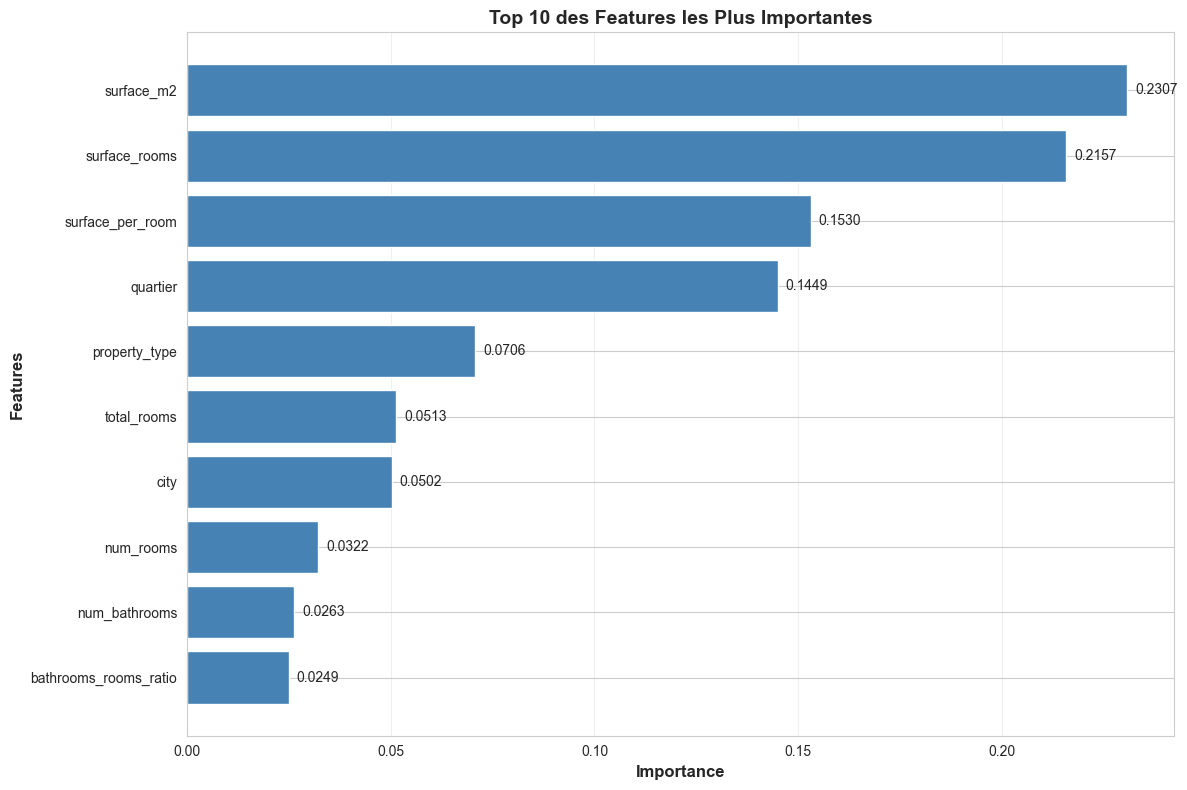


📈 Pouvoir explicatif cumulé :
   Top 3 features : 59.9%
   Top 5 features : 81.5%
   Top 10 features : 100.0%

📊 Nombre total de features : 10

✅ Analyse des features terminée !


In [14]:
# ============================================
# ANALYSE DE L'IMPORTANCE DES FEATURES
# ============================================

print("\n" + "="*60)
print("ANALYSE DE L'IMPORTANCE DES FEATURES")
print("="*60)

# Extraire les importances
feature_importance = best_model.feature_importances_
feature_names = X_train_scaled.columns.tolist()

# Créer un DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n📊 Top features les plus importantes :")
print(importance_df.head(15).to_string(index=False))

# Visualisation - adapter le nombre de features au nombre réel disponible
plt.figure(figsize=(12, 8))
top_n = min(15, len(importance_df))  # Prendre le minimum entre 15 et le nombre total de features
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['Importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.ylabel('Features', fontweight='bold', fontsize=12)
plt.title(f'Top {top_n} des Features les Plus Importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Ajouter les valeurs sur les barres
for i, (feat, imp) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
    plt.text(imp + 0.002, i, f'{imp:.4f}', va='center', fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculer le pourcentage cumulé
importance_df['Cumulative %'] = (importance_df['Importance'].cumsum() / 
                                  importance_df['Importance'].sum() * 100)

print(f"\n📈 Pouvoir explicatif cumulé :")
for i in [3, 5, 10]:
    if i <= len(importance_df):
        cumul = importance_df.iloc[:i]['Cumulative %'].iloc[-1]
        print(f"   Top {i} features : {cumul:.1f}%")

print(f"\n📊 Nombre total de features : {len(importance_df)}")
print("\n✅ Analyse des features terminée !")

## 10. Sauvegarde du Modèle

In [16]:
# ============================================
# SAUVEGARDE DU MODÈLE OPTIMISÉ
# ============================================

# Créer le dossier models s'il n'existe pas
os.makedirs('../models', exist_ok=True)

print("="*60)
print("SAUVEGARDE DU MODÈLE OPTIMISÉ")
print("="*60)
print()

# --- ETAPE AJOUTÉE : Calcul des métriques de TEST ici ---
# On calcule les variables manquantes avant de les utiliser
y_test_pred = best_model.predict(X_test_scaled)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
# --------------------------------------------------------

# 1. Sauvegarder le modèle Gradient Boosting optimisé
model_path = '../models/gradient_boosting_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ Modèle Gradient Boosting sauvegardé : {model_path}")

# 2. Sauvegarder le Target Encoder
encoder_path = '../models/target_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(target_encoder, f)
print(f"✓ Target Encoder sauvegardé : {encoder_path}")

# 3. Sauvegarder le StandardScaler
scaler_path = '../models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ StandardScaler sauvegardé : {scaler_path}")

# 4. Sauvegarder les feature names
features_path = '../models/feature_names.pkl'
feature_names_dict = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'all_features': numeric_features + categorical_features
}
with open(features_path, 'wb') as f:
    pickle.dump(feature_names_dict, f)
print(f"✓ Feature names sauvegardés : {features_path}")

# 5. Créer un fichier CSV de résumé
summary_data = {
    'model_name': ['Gradient Boosting (Optimisé)'],
    'r2_train': [r2_score(y_train, best_model.predict(X_train_scaled))],
    'r2_validation': [r2_score(y_val, y_val_pred)], # y_val_pred vient du bloc précédent
    'r2_test': [r2_test],
    'mae_test': [mae_test],
    'rmse_test': [rmse_test],
    'mape_test': [mape_test],
    'date_training': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
    'train_samples': [len(X_train)],
    'val_samples': [len(X_val)],
    'test_samples': [len(X_test)],
    'total_features': [len(numeric_features + categorical_features)]
}

summary_df = pd.DataFrame(summary_data)
summary_path = '../models/model_performance_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"✓ Résumé de performance sauvegardé : {summary_path}")

# 6. Afficher le résumé
r2_train_final = r2_score(y_train, best_model.predict(X_train_scaled))

print("\n" + "="*60)
print("RÉSUMÉ FINAL DU MODÈLE")
print("="*60)

print(f"\n📊 PERFORMANCES :")
print(f"   R² Train       : {r2_train_final:.4f}")
print(f"   R² Validation  : {r2_score(y_val, y_val_pred):.4f}")
print(f"   R² Test        : {r2_test:.4f}")
print(f"   MAE Test       : {mae_test:,.0f} DH")
print(f"   RMSE Test      : {rmse_test:,.0f} DH")
print(f"   MAPE Test      : {mape_test:.2f}%")

print(f"\n✓ Écart train/test (surapprentissage) : {abs(r2_train_final - r2_test):.4f}")

if abs(r2_train_final - r2_test) < 0.05:
    print("   ✅ Excellente généralisation")
elif abs(r2_train_final - r2_test) < 0.15:
    print("   ✅ Bonne généralisation")
else:
    print("   ⚠️ Possible surapprentissage")

print(f"\n✓ Tous les fichiers sont sauvegardés dans : ../models/")
print("="*60)
print("✅ Entraînement et sauvegarde terminés avec succès!")
print("="*60)

SAUVEGARDE DU MODÈLE OPTIMISÉ

✓ Modèle Gradient Boosting sauvegardé : ../models/gradient_boosting_model.pkl
✓ Target Encoder sauvegardé : ../models/target_encoder.pkl
✓ StandardScaler sauvegardé : ../models/scaler.pkl
✓ Feature names sauvegardés : ../models/feature_names.pkl
✓ Résumé de performance sauvegardé : ../models/model_performance_summary.csv

RÉSUMÉ FINAL DU MODÈLE

📊 PERFORMANCES :
   R² Train       : 0.7205
   R² Validation  : 0.5841
   R² Test        : 0.5264
   MAE Test       : 1,515,671 DH
   RMSE Test      : 3,268,247 DH
   MAPE Test      : 97.79%

✓ Écart train/test (surapprentissage) : 0.1941
   ⚠️ Possible surapprentissage

✓ Tous les fichiers sont sauvegardés dans : ../models/
✅ Entraînement et sauvegarde terminés avec succès!
